In [1]:
!pip install -q kaggle

from google.colab import files
files.upload()
# Chọn file kaggle.json tải về ở bước 2 để tải lên

!mkdir '/root/.kaggle'
!cp kaggle.json '/root/.kaggle'
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets list
# Chạy lệnh liệt kê các bộ dữ liệu của bạn để đảm bảo bạn đã cài đặt thành công

Saving kaggle.json to kaggle.json
ref                                                                   title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                                 Data Science Salaries 2023 💸                      25KB  2023-04-13 09:55:16          39021       1114  1.0              
tawfikelmetwally/automobile-dataset                                   Car information dataset                            6KB  2023-05-28 18:26:48           6541        164  0.9411765        
fatihb/coffee-quality-data-cqi                                        Coffee Quality Data (CQI May-2023)                22KB  2023-05-12 13:06:39           8169        169  1.0              
mohithsaira

In [2]:
!kaggle datasets download -d tlor01/dataset-final

 87% 102M/117M [00:00<00:00, 105MB/s] 
100% 117M/117M [00:01<00:00, 115MB/s]
 92% 277M/300M [00:03<00:00, 113MB/s]
100% 300M/300M [00:03<00:00, 92.0MB/s]


In [3]:
!unzip -q dataset-final.zip

  Preparing metadata (setup.py) ... done
  Created wheel for progress: filename=progress-1.6-py3-none-any.whl size=9611 sha256=45d74f7610cc77d21c0fa2531379b37d73b5ffa0a2eb563eb2cffa54ad516356
  Stored in directory: /root/.cache/pip/wheels/a2/68/5f/c339b20a41659d856c93ccdce6a33095493eb82c3964aac5a1
Successfully built progress
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=e881d0454c5af6b693cab3e7b5cb13d96ba754e68d38930f0c9e897a5384d6a1
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


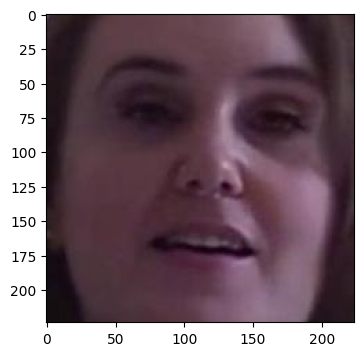

In [4]:
!pip install scikit-image
!pip install progress
!pip install einops
!pip install efficientnet_pytorch
import torch
import numpy as np
from torch.optim import lr_scheduler
import os
import json
from multiprocessing.pool import Pool
from functools import partial
from multiprocessing import Manager
import matplotlib.pyplot as plt
from progress.bar import ChargingBar
import cv2
import seaborn as sns
import glob
import pandas as pd
from tqdm import tqdm
import collections
import math
import h5py
from statistics import mean

from skimage.transform import resize

img = "/content/dataset_final/training_set/FAKE/aouzlroqzt_FAKE_4.jpg"
image = cv2.imread(img)[..., ::-1]
plt.figure(figsize=(4, 4))
plt.imshow(image.astype("uint8"))


In [5]:
from sklearn import metrics
from sklearn.metrics import auc

def save_roc_curves(correct_labels, preds, model_name, accuracy, loss, f1):
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')

    fpr, tpr, th = metrics.roc_curve(correct_labels, preds)

    model_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label="Model_" + "ViT" +
             ' (area = {:.3f})'.format(model_auc))

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.savefig(os.path.join("/content/", "ViT" + "_" +"_acc" + str(accuracy*100) + "_loss"+str(loss)+"_f1"+str(f1)+".jpg"))
    plt.clf()

def custom_round(values):
    result = []
    for value in values:
        if value > 0.55:
            result.append(1)
        else:
            result.append(0)
    return np.asarray(result)

def custom_video_round(preds):
    return mean(preds)


def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
def check_correct(preds, labels):
    preds = preds.cpu()
    labels = labels.cpu()
    preds = [np.asarray(torch.sigmoid(pred).detach().numpy()).round() for pred in preds]

    correct = 0
    positive_class = 0
    negative_class = 0
    for i in range(len(labels)):
        pred = int(preds[i])
        if labels[i] == pred:
            correct += 1
        if pred == 1:
            positive_class += 1
        else:
            negative_class += 1
    return correct, positive_class, negative_class

In [6]:
import torch
from torch.utils.data import  Dataset
import cv2
import numpy as np
import torchvision.transforms as transforms
from PIL import Image


train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

class DeepFakesDataset(Dataset):
    def __init__(self, images, labels, is_train=False):
        self.x = images
        self.y = torch.from_numpy(labels)
        self.is_train = is_train
        if self.is_train:
            self.transform = train_transforms
        self.n_samples = images.shape[0]

    def __getitem__(self, index):
        image = np.asarray(self.x[index])
        if self.is_train:
            image = Image.fromarray(image)
            image = self.transform(image)
        return torch.tensor(image).float(), self.y[index]

    def __len__(self):
        return self.n_samples


In [17]:
import torch
from torch import nn
from einops import rearrange
from efficientnet_pytorch import EfficientNet
from torch import einsum
from einops import repeat
import torchvision.models as models
from math import sqrt
import torch.nn.functional as F
from einops.layers.torch import Rearrange

import torch
from torch import nn
from einops import rearrange
from efficientnet_pytorch import EfficientNet
from torch import einsum
from einops import repeat
import torchvision.models as models
from torchvision.models import resnet50

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class ExcludeCLS(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        cls_token, x = x[:, :1], x[:, 1:]
        x = self.fn(x, **kwargs)
        return torch.cat((cls_token, x), dim = 1)

class PatchDropout(nn.Module):
    def __init__(self, prob):
        super().__init__()
        assert 0 <= prob < 1.
        self.prob = prob

    def forward(self, x):
        if not self.training or self.prob == 0.:
            return x

        b, n, _, device = *x.shape, x.device

        batch_indices = torch.arange(b, device = device)
        batch_indices = rearrange(batch_indices, '... -> ... 1')
        num_patches_keep = max(1, int(n * (1 - self.prob)))
        patch_indices_keep = torch.randn(b, n, device = device).topk(num_patches_keep, dim = -1).indices

        return x[batch_indices, patch_indices_keep]

class DepthWiseConv2d(nn.Module):
    def __init__(self, dim_in, dim_out, kernel_size, padding, stride = 1, bias = True):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(dim_in, dim_in, kernel_size = kernel_size, padding = padding, groups = dim_in, stride = stride, bias = bias),
            nn.Conv2d(dim_in, dim_out, kernel_size = 1, bias = bias)
        )
    def forward(self, x):
        return self.net(x)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(dim, hidden_dim, 1),
            nn.Hardswish(),
            DepthWiseConv2d(hidden_dim, hidden_dim, 3, padding = 1),
            nn.Hardswish(),
            nn.Dropout(dropout),
            nn.Conv2d(hidden_dim, dim, 1),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        h = w = int(sqrt(x.shape[-2]))
        x = rearrange(x, 'b (h w) c -> b c h w', h = h, w = w)
        x = self.net(x)
        x = rearrange(x, 'b c h w -> b (h w) c')
        return x


class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class EfficientNetWrapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.efficient_net = EfficientNet.from_pretrained('efficientnet-b0')

        for i in range(0, len(self.efficient_net._blocks)):
            for index, param in enumerate(self.efficient_net._blocks[i].parameters()):
                if i >= len(self.efficient_net._blocks) - 3:
                    param.requires_grad = True
                else:
                    param.requires_grad = False

    def forward(self, x):
        return self.efficient_net.extract_features(x)

class FullyConnectedLayer(nn.Module):
    def __init__(self, dim, mlp_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(dim, mlp_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(mlp_dim, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout))),
                ExcludeCLS(Residual(PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x)
            x = ff(x)
        return x

class EfficientViT(nn.Module):
    def __init__(self, channels=512, selected_efficient_net=0):
        super().__init__()

        image_size = 224
        patch_size = 7
        num_classes = 1
        dim = 1024
        depth = 6
        heads = 8
        mlp_dim = 1024
        emb_dim = 32
        dim_head = 64
        dropout = 0.25
        emb_dropout = 0.25
        patch_dropout = 0.25
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'

        self.efficient_net = EfficientNetWrapper()

        num_patches = (7 // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(emb_dim, 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        # Them moi
        self.patch_dropout = PatchDropout(patch_dropout)
        self.dropout = nn.Dropout(emb_dropout)
        self.transformer = Transformer(
            dim, depth, heads, dim_head, mlp_dim, dropout)

        self.to_cls_token = nn.Identity()

        self.mlp_head = FullyConnectedLayer(dim, mlp_dim, num_classes)

    def forward(self, img, mask=None):
        p = self.patch_size
        x = self.efficient_net(img)  # 1280x7x7
        y = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        y = self.patch_to_embedding(y)
        x = self.patch_dropout(y)
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), 1)
        shape = x.shape[0]
        x += self.pos_embedding[0:shape]
        x = self.dropout(x)
        x = self.transformer(x)
        x = self.to_cls_token(x[:, 0])
        x = self.mlp_head(x)
        return x


In [18]:
model = EfficientViT(channels=1280)

model.train()

optimizer = torch.optim.SGD(model.parameters(),
    lr=0.001, weight_decay=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
starting_epoch = 0

print("Model Parameters:", get_n_params(model))

Loaded pretrained weights for efficientnet-b0
Model Parameters: 102167141


In [14]:
image_size = 224
labels = ('REAL', 'FAKE')
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[..., ::-1]
                resized_arr = cv2.resize(img_arr, (image_size, image_size))
                data.append((resized_arr, class_num))
            except Exception as e:
                print(e)
    return np.array(data, dtype='object')

train_dataset = get_data("/content/dataset_final/training_set")
validation_dataset = get_data("/content/dataset_final/validation_set")

print("Train images:", len(train_dataset),
      "Validation images:", len(validation_dataset))
train_samples = len(train_dataset)
validation_samples = len(validation_dataset)
train_counters = collections.Counter(image[1] for image in train_dataset)
print(train_counters)

class_weights = train_counters[0] / train_counters[1]
loss_fn = torch.nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor([class_weights]))
validation_labels = np.asarray([row[1] for row in validation_dataset])
labels = np.asarray([row[1] for row in train_dataset])
image_size = 224
train_dataset = DeepFakesDataset(np.asarray(
        [row[0] for row in train_dataset]), labels, is_train=False)
dl = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
del train_dataset

validation_dataset = DeepFakesDataset(np.asarray(
        [row[0] for row in validation_dataset]), validation_labels, is_train=False)
val_dl = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=True, num_workers=2)
del validation_dataset

Train images: 20000 Validation images: 3546
Counter({0: 10000, 1: 10000})


In [10]:
from progress.bar import Bar
from sklearn.metrics import accuracy_score, auc, f1_score
import torch
import torch.nn.functional as F
image_size = 224

def custom_round1(values):
    result = 0
    if values > 0.55:
        result = 1
    else:
        result = 0
    return result
def check_real(real_text):
    if(real_text == "REAL"):
        labelTest = 0
    else:
        labelTest = 1
    return labelTest
def read_frames(video_path, videos,labels):
    frames_paths1 = os.listdir(video_path)
    frames_paths_dict = {}

    for path in frames_paths1:
        key = path.split('_')[0]+"_"+path.split('_')[1]
        if key not in frames_paths_dict.keys():
            frames_paths_dict[key] = [path]
        else:
            frames_paths_dict[key].append(path)

    video = {}
    for key in frames_paths_dict.keys():
        for index, frame_image in enumerate(frames_paths_dict[key]):
            img_arr = cv2.imread(os.path.join(video_path, frame_image))[..., ::-1]
            resized_arr = cv2.resize(img_arr, (image_size, image_size))
            if len(img_arr) > 0:
                video.setdefault(key, []).append(resized_arr)
        real_text = key.split("_")[1]
        if(real_text == "REAL"):
            labelTest = 0
        else:
            labelTest = 1
        labels.append(labelTest)
    videos.append(video)


mgr = Manager()
paths_val = []

videos_val = mgr.list()
labels_val = mgr.list()

folders = ["REAL", "FAKE"]
valfile = "/content/dataset_final/validation_set"


for folder in folders:

    paths_val.append(os.path.join(valfile, folder))

for path in paths_val:
    read_frames(video_path=path, videos=videos_val,labels=labels_val)

print(len(videos_val))

2


In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, auc, f1_score


counter = 0
not_improved_loss = 0
previous_loss = math.inf

train_accuracy_values = []
train_loss_values = []
val_accuracy_values = []
val_loss_values = []
val_video_accuracy_values = []
val_video_loss_values = []

for t in range(starting_epoch, 20):
    if not_improved_loss == 5:
        break
    counter = 0
    model = model.cuda()
    total_loss = 0
    total_val_loss = 0
    model = model.train()
    train_progress_bar = tqdm(total=len(dl), desc='Training', position=0)
    train_correct = 0
    positive = 0
    negative = 0
    for index, (images, labels) in enumerate(dl):
        images = np.transpose(images, (0, 3, 1, 2))
        labels = labels.unsqueeze(1)
        images = images.cuda()

        y_pred = model(images)
        y_pred = y_pred.cpu()

        loss = loss_fn(y_pred, labels.float())

        corrects, positive_class, negative_class = check_correct(
            y_pred, labels)
        train_correct += corrects
        positive += positive_class
        negative += negative_class
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        counter += 1
        total_loss += round(loss.item(), 2)

        train_progress_bar.set_postfix(loss='{:.4f}'.format(total_loss / counter),
                                       accuracy='{:.4f}'.format(train_correct / (counter * 32)))
        train_progress_bar.update()

        if (index + 1) % 1200 == 0:
            print('Batch [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'.format(index + 1, len(dl),
                                                                          total_loss / counter,
                                                                          train_correct / (counter * 32)))

    train_progress_bar.close()

    val_correct = 0
    val_positive = 0
    val_negative = 0
    val_counter = 0
    train_correct /= train_samples
    total_loss /= counter

    val_progress_bar = tqdm(total=len(val_dl), desc='Validation', position=0)
    for index, (val_images, val_labels) in enumerate(val_dl):
        val_images = np.transpose(val_images, (0, 3, 1, 2))
        val_images = val_images.cuda()
        val_labels = val_labels.unsqueeze(1)
        val_pred = model(val_images)
        val_pred = val_pred.cpu()
        val_loss = loss_fn(val_pred, val_labels.float())
        total_val_loss += round(val_loss.item(), 2)
        corrects, positive_class, negative_class = check_correct(
            val_pred, val_labels)
        val_correct += corrects
        val_positive += positive_class
        val_counter += 1
        val_negative += negative_class

        val_progress_bar.set_postfix(val_loss='{:.4f}'.format(total_val_loss / val_counter),
                                     val_accuracy='{:.4f}'.format(val_correct / validation_samples))
        val_progress_bar.update()

    val_progress_bar.close()


    val_video_progress_bar = tqdm(total=(len(videos_val[0])+len(videos_val[1])), desc='Validation Video', position=0)
    model = model.eval()
    preds = []
    for index, video in enumerate(videos_val):
        video_faces_preds = []
        for key in video:
            faces_preds = []
            video_faces = video[key]
            for i in range(0, len(video_faces), 32):
                faces = video_faces[i:i+32]
                faces = torch.tensor(np.asarray(faces))
                if faces.shape[0] == 0:
                    continue
                faces = np.transpose(faces, (0, 3, 1, 2))
                faces = faces.cuda().float()
                pred = model(faces)
                scaled_pred = []
                for idx, p in enumerate(pred):
                    scaled_pred.append(torch.sigmoid(p))
                faces_preds.extend(scaled_pred)
            current_faces_pred = sum(faces_preds)/len(faces_preds)
            face_pred = current_faces_pred.cpu().detach().numpy()[0]
            video_faces_preds.append(face_pred)
            val_video_progress_bar.set_postfix(face_pred ='{:.4f}'.format(face_pred),label = '{:.2f}'.format(check_real(key.split('_')[1])))
            val_video_progress_bar.update()
        preds.append(video_faces_preds)
    val_video_progress_bar.close()
    loss_fn = torch.nn.BCEWithLogitsLoss()
    test_preds_list = [item for sublist in preds for item in sublist]

    preds_list = [[item] for item in test_preds_list]
    labels_list = [[item] for item in labels_val]

    tensor_labels = torch.tensor([[float(label)] for label in labels_val])
    tensor_preds = torch.tensor(preds_list)

    loss_video = loss_fn(tensor_preds, tensor_labels).numpy()
    accuracy_video = accuracy_score(custom_round(np.asarray(preds_list)),np.array(labels_val, dtype='int'))

    scheduler.step()

    total_val_loss /= val_counter
    val_correct /= validation_samples

    if previous_loss <= total_val_loss:
        print("Validation loss did not improve")
        not_improved_loss += 1
    else:
        not_improved_loss = 0

    previous_loss = total_val_loss
    print("#" + str(t) + "/" + str(20) + " loss:" +
          str(total_loss) + " accuracy:" + str(train_correct) + " val_loss:" + str(total_val_loss) + " val_accuracy:" + str(val_correct) + " val_0s:" + str(val_negative) + "/" + str(np.count_nonzero(validation_labels == 0)) + " val_1s:" + str(val_positive) + "/" + str(np.count_nonzero(validation_labels == 1)))
    print("#" + str(t) + "/" + str(20) + " validation video loss:" +str(loss_video) + " validation video accuracy:" + str(accuracy_video))
    # Lưu giá trị của accuracy và loss

    train_accuracy_values.append(train_correct)
    train_loss_values.append(total_loss)
    val_accuracy_values.append(val_correct)
    val_loss_values.append(total_val_loss)
    val_video_accuracy_values.append(accuracy_video)
    val_video_loss_values.append(loss_video)

torch.save(model.state_dict(), '/content/EfficientViT_checkpoint_39.pt')
model.cpu()
state_dict = model.state_dict()



# Vẽ đồ thị
epochs_range = range(starting_epoch, 20)

plt.figure(figsize=(15, 15))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_accuracy_values, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy_values, label='Validation Accuracy')
plt.plot(epochs_range, val_video_accuracy_values, label='Validation Video Accuracy')

plt.legend(loc='lower right')
plt.title('Training, Validation and Validation Video Accuracy')

# Loss
plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_loss_values, label='Training Loss')
plt.plot(epochs_range, val_loss_values, label='Validation Loss')
plt.plot(epochs_range, val_video_loss_values, label='Validation Video Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation and Validation Video Loss')

plt.show()

# Tính toán ma trận nhầm lẫn
threshold = 0.55  # Ngưỡng để phân loại

y_true = [1 if item > threshold else 0 for sublist in labels_list for item in sublist]
y_pred = [1 if item > threshold else 0 for sublist in preds_list for item in sublist]
print(y_true)
print(y_pred)
# Vẽ ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred)
classes = ['REAL', 'FAKE']  # Thay đổi tên lớp nếu cần thiết
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()

Loaded pretrained weights for efficientnet-b0
ViT  Test Accuracy: 0.9248554913294798 Loss: 0.5764519 F1 0.9207317073170732
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

<Figure size 640x480 with 0 Axes>

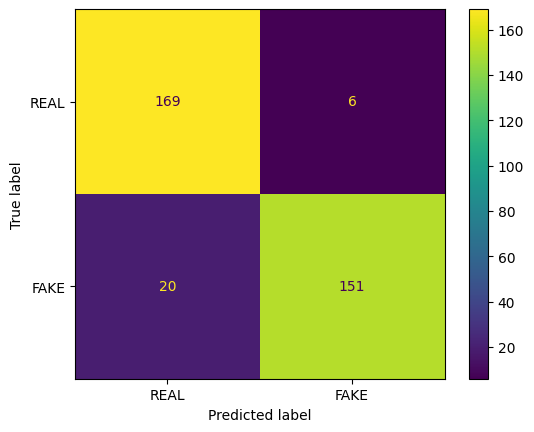

In [ ]:
from progress.bar import Bar
from sklearn.metrics import accuracy_score, auc, f1_score
import torch
import torch.nn.functional as F


modelTest = EfficientViT(channels=1280, selected_efficient_net=0)
modelTest.load_state_dict(torch.load(
        '/content/EfficientViT_checkpoint_39.pt'))
modelTest.eval()
modelTest = modelTest.cuda()
model_name = "ViT"

mgr = Manager()
paths = []
videos = mgr.list()
labels = mgr.list()

folders = ["REAL", "FAKE"]
tfile = "/content/dataset_final/test_set"
for folder in folders:
    paths.append(os.path.join(tfile, folder))

for path in paths:
    read_frames(video_path=path, videos=videos,labels=labels)

preds = []

bar = Bar('Predicting', max=len(videos))
output_file_path = os.path.join("/content/DFDC" + "_" + "DetectDeepfake" + "_labels.txt")
# Mở tệp tin để ghi dữ liệu
with open(output_file_path, "w+") as file:
    # Ghi dữ liệu vào tệp tin
    for index, video in enumerate(videos):
        video_faces_preds = []
        for key in video:
            faces_preds = []
            video_faces = video[key]
            for i in range(0, len(video_faces), 32):
                faces = video_faces[i:i+32]
                faces = torch.tensor(np.asarray(faces))
                if faces.shape[0] == 0:
                    continue
                faces = np.transpose(faces, (0, 3, 1, 2))
                faces = faces.cuda().float()
                pred = modelTest(faces)
                scaled_pred = []
                for idx, p in enumerate(pred):
                    scaled_pred.append(torch.sigmoid(p))
                faces_preds.extend(scaled_pred)
            current_faces_pred = sum(faces_preds)/len(faces_preds)
            face_pred = current_faces_pred.cpu().detach().numpy()[0]
            file.write(key + " " + str(face_pred)+" "+str(custom_round1(face_pred)))
            file.write(" --> " "(CORRECT: " +str(check_real(key.split('_')[1])) + ")" + "\n")
            video_faces_preds.append(face_pred)
        bar.next()
        preds.append(video_faces_preds)
bar.finish()
loss_fn = torch.nn.BCEWithLogitsLoss()
test_preds_list = [item for sublist in preds for item in sublist]

preds_list = [[item] for item in test_preds_list]
labels_list = [[item] for item in labels]

tensor_labels = torch.tensor([[float(label)] for label in labels])
tensor_preds = torch.tensor(preds_list)

loss = loss_fn(tensor_preds, tensor_labels).numpy()
accuracy = accuracy_score(custom_round(np.asarray(preds_list)),np.array(labels, dtype='int'))

f1 = f1_score(np.array(labels, dtype='int'), custom_round(np.asarray(preds_list)))
print("ViT ", "Test Accuracy:", accuracy, "Loss:", loss, "F1", f1)
save_roc_curves(np.array(labels, dtype='int'), preds_list, "ViT", accuracy, loss, f1)

# Tính toán ma trận nhầm lẫn
threshold = 0.55  # Ngưỡng để phân loại

y_true = [1 if item > threshold else 0 for sublist in labels_list for item in sublist]
y_pred = [1 if item > threshold else 0 for sublist in preds_list for item in sublist]
# Vẽ ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred)
classes = ['REAL', 'FAKE']  # Thay đổi tên lớp nếu cần thiết
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()